# Figure 7

This notebook recreates the figure panels included in Figure 7 of Lee et al. 2021. 



### Description of the Data

The data used in this notebook comes from the experiments described in Lee et al. 2021. We trained the distributional RL model on the same data the deepRL network used.




## Preparing the Data
### Importing required code packages and modules

In [1]:
ls

Figure 2.ipynb       Figure 5.ipynb       Figure 8.ipynb
Figure 3.ipynb       Figure 6.ipynb       Supp Figures.ipynb
Figure 3_OLD.ipynb   Figure 7.ipynb       utils/
Figure 4.ipynb       Figure 7_supp.ipynb


In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sys
from scipy.io import loadmat, savemat
import utils.cnnlstm_analysis_utils as cnn_utils
import utils.distRL_utils as utils
import seaborn as sns
from scipy import stats
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import os

from scipy.stats import zscore

Missing colon in file '/Users/sasha/.matplotlib/matplotlibrc', line 1 ('~/.matplotlib/matplotlibrc')


### downloading data

In [2]:
load_prefix = '../data/logs/distRL/'

data_load_prefix = '../../data/logs/VA_maze/'
with open(data_load_prefix + '5000t_mosttrain_db.p', 'rb') as f:
    [actions_, rewards_, feats_, terms_, vs_,
        tow_counts_, episode_lengths] = pickle.load(f)
f.close()

vs = np.hstack(vs_)
terms = np.hstack(terms_)
rewards = np.hstack(rewards_)
ep_rew = np.array([np.sum(r_trial) for r_trial in rewards_])
ep_tow = np.array([np.max(trial, 0) for trial in tow_counts_])
tow_counts = np.vstack(tow_counts_)


with open(data_load_prefix + '10K_moretrials.p', 'rb') as f:
    [_, rewards2, feats2_, _, _, tow_counts2,
        episode_lengths2] = pickle.load(f)
f.close()


feats_all = feats_ + feats2_
episode_lengths_all = np.hstack([episode_lengths, episode_lengths2])
ep_rew_all = np.hstack(
    [ep_rew, np.array([np.sum(r_trial) for r_trial in rewards2])])
ep_tow_all = np.vstack(
    [ep_tow, np.array([np.max(trial, 0) for trial in tow_counts2])])


trial_info = loadmat(data_load_prefix + 'trialinfo_db.mat')

trial_info = trial_info['trials']
trial_info.dtype.names

choices = cnn_utils.extract_field(trial_info, 'choice')
trial_type = cnn_utils.extract_field(trial_info, 'trialType')
raw_ypos = cnn_utils.extract_field(trial_info, 'position')[:, 1]
cueCombos_ = cnn_utils.extract_field(trial_info, 'cueCombo')
cuePos_ = cnn_utils.extract_field(trial_info, 'cuePos')
cueOnset_ = cnn_utils.extract_field(trial_info, 'cueOnset')
raw_ypos_ = [x[:, 1] for x in trial_info['position'][0]]
raw_xpos_ = [x[:, 0] for x in trial_info['position'][0]]
raw_vpos_ = [x[:, 2] for x in trial_info['position'][0]]
ypos_ = [np.hstack([np.array(x[:-1]), x[-2] * np.ones((7,))])
         for x in raw_ypos_]
ypos = np.hstack(ypos_)


weights = cnn_utils.get_params_from_zip(
    data_load_prefix + 'rl_model_20800000_steps')
# weights.keys()

w_val = np.squeeze(weights['model/vf/w:0'])




### Plotting Parameters

In [3]:
# PLOTTING PARAMS
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.family': 'Arial'})

FONT_BG = 25
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

marker_plots =  {'marker':'.', 'markersize':2, 'markeredgecolor':'k', 'markerfacecolor':'k'}

heatmap_sz = (4, 3.5)
example_sz = (4, 1)

left_col = 'red'
right_col = 'deepskyblue'


## Get the Expectile PE
### Training the weights

In [4]:
# load directly if the weights and features were already trained 
w = pickle.load(open(load_prefix + "learned_dist_weights.p", "rb"))

[dist_pes_raw, vs_, w] = pickle.load(
    open(load_prefix + 'trained_distRL_pes.p', "rb"))
num_dists = dist_pes_raw[0].shape[1]



In [5]:
dist_pes_raw[0].shape

(145, 31, 31)

In [6]:
k = 0.001  # alpha_plus + alpha_minus = k
num_dists = 31
# tau = alpha_plus / [alpha_plus + alpha_minus] # not including boundary matching lowet et al's
tau = (2 * np.arange(1, num_dists + 1) - 1) / num_dists / 2
alpha_plus, alpha_minus = utils.get_alphas(tau, k)
gamma = 0.99

ep_rewidx = (episode_lengths - 11).astype(int)
feats_torew_ = [feats_i[:rew_idx + 1, :]
                for [feats_i, rew_idx] in zip(feats_, ep_rewidx)]
# z-scoring across all episodes/trials for *each* feature
norm_feats_torew = cnn_utils.split_by_ep_len(
    zscore(np.vstack([pes_i for pes_i in feats_torew_]), 0), ep_rewidx + 1)


feats_to_train = norm_feats_torew  # sim_feats  #
# sim_ep_len   #  # need + 1to reach the actual reward
ep_len_to_train = ep_rewidx + 1
num_trials = len(ep_len_to_train)

rewards_to_train = ep_rew_all[:num_trials]  # sim_rew  #  #
num_feats = len(w_val)  # num_states  #   #



In [14]:
# PART 1: TRAINING THE WEIGHTS W
w = np.zeros((num_dists, num_feats + 1))  # now V becomes (num_dist,)
vs_ = []
dist_pes_ = []  # np.zeros((feats_[0].shape[1], num_timesteps, num_trials))
for trial in np.arange(num_trials):
    pes_tr = np.zeros((int(ep_len_to_train[trial]), num_dists))
    vs_tr = np.zeros((int(ep_len_to_train[trial]), num_dists))
    for ts in np.flip(np.arange(int(ep_len_to_train[trial]))):
        V = w @ np.hstack([feats_to_train[trial][ts, :], 1])  # num_dists x 1
        vs_tr[ts, :] = V

        # using TD-1, dynamic programming now. it's ts - 1 since np.arange is 0-indexed
        pes_tr[ts, :] = rewards_to_train[trial] * \
            gamma**(ep_len_to_train[trial] - ts - 1) - V

        # alpha = alpha_plus * 1 if pes > 0
        # alpha = alpha_neg * -1 if pes < 0

        # for sample_i in np.arange(num_samples):
        indic = pes_tr[ts, :] <= 0

        """
        determining expectile vs quantile
        quantile uses np.sign (delta):  (np.sign(pes_tr[ts, :, :]))
        expectile uses delta:  pes[ts,:,:]
        """
        method_update = pes_tr[ts, :]
        alpha_ts = method_update * \
            (indic * alpha_minus + (1 - indic) * alpha_plus)

        norm_factor = 1 / \
            np.dot(feats_to_train[trial][ts, :], feats_to_train[trial][ts, :])

        alpha_ts = alpha_ts * norm_factor

        w = w + np.outer(alpha_ts,
                         np.hstack([feats_to_train[trial][ts, :], 1]))

    dist_pes_.append(pes_tr)
    vs_.append(vs_tr)

    
# pickle.dump(w, open("learned_dist_weights.p", "wb"))

KeyboardInterrupt: 

### Training the distributional features with TD-0

In [ ]:
# PART 2: GET DISTRIBUTIONAL FEATURES WITH THE FROZEN WEIGHTS W

num_trials = 5000 # only get PEs for the 5000 trials. This takes about 1.5 hours to run 
rewards_to_train = rewards_[:num_trials]  # sim_rew  #  #
num_samples = num_dists

In [15]:

vs_ = []
dist_pes_ = []  # np.zeros((feats_[0].shape[1], num_timesteps, num_trials))
for trial in np.arange(num_trials):
    if (np.mod(trial, 500) == 0):
        print(trial)

    pes_tr = np.zeros((int(ep_len_to_train[trial]), num_dists, num_samples))
    vs_tr = np.zeros((int(ep_len_to_train[trial]), num_dists))
    for ts in np.flip(np.arange(int(ep_len_to_train[trial]))):
        V = w @ np.hstack([feats_to_train[trial][ts, :], 1])  # num_dists x 1
        vs_tr[ts, :] = V

       # terminal state
        if ts == (ep_len_to_train[trial] - 1):
            # NUM_DISTS x NUM_SAMPLES all samples get the same result here
            pes_tr[ts, :, :] = np.tile(
                rewards_to_train[trial][ts] - V, (num_samples, 1)).T

        else:

            V_next = w @ np.hstack([feats_to_train[trial][ts + 1, :], 1])
            V_samples = utils.infer_dist(V_next, tau)
            # this is returning nan
            # averaging across all samples

            pes_tr[ts, :, :] = np.tile(
                rewards_to_train[trial][ts], (num_dists, num_samples)) + np.subtract.outer(gamma * V_samples, V).T

    dist_pes_.append(pes_tr)
    vs_.append(vs_tr)

0
Number of calls to function has reached maxfev = 100000.


KeyboardInterrupt: 

### Organizing Data

Pulling out the specific data that we will use for figure panels

In [107]:
# injecting noise at the end of every trial 

dist_pes_noise = [pes_i + np.vstack([np.zeros((np.shape(pes_i)[0] -1 , num_dists, num_dists)), np.random.normal(0, 10, (1, num_dists, num_dists))]) for pes_i in dist_pes_raw]

In [108]:

dist_pes_ = [np.nanmean(pes_i, -1) for pes_i in dist_pes_noise]

CUEP_LIM = 140
ypos_cuep = np.squeeze(np.dstack([ypos_t[:CUEP_LIM]
                       for ypos_t in ypos_])[:, :, 0])

dist_cuep_flat = np.vstack([pes_i[:CUEP_LIM] for pes_i in dist_pes_])
dist_pes = np.vstack([pes_i for pes_i in dist_pes_])

ep_rewidx = (episode_lengths - 11).astype(int)

(ep_towdelt_idx, ep_towdiff_idx) = cnn_utils.get_ep_tow_idx(ep_tow)

# pickle.dump(TD_phi_trained_, open("trained_sf_pes.p", "wb"))

/var/folders/lr/h5lrlljd6fg1v7kbc9cn2_sw0000gn/T/ipykernel_86698/3883304825.py:1: RuntimeWarning: Mean of empty slice
  dist_pes_ = [np.nanmean(pes_i, -1) for pes_i in dist_pes_noise]


### Figure 6B: View Angle Responses

In [62]:
vpos_cuep_flat = np.round(
    np.hstack([trial[:CUEP_LIM] for trial in raw_vpos_]), 2)


pes_cuep_vabinned = cnn_utils.bin_data_by_vpos(
    dist_cuep_flat, vpos_cuep_flat)

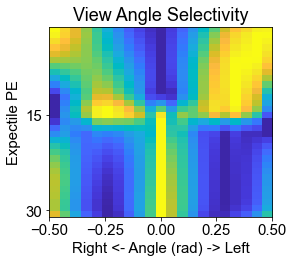

In [63]:
fig, ax_va = plt.subplots(figsize=heatmap_sz)
ax_va.imshow(cnn_utils.norm_within_feat(pes_cuep_vabinned),
             aspect='auto', extent=[-0.5, 0.5, 31, 1], cmap=cnn_utils.parula_map, interpolation='none')


ax_va.set_yticks([15, 30])  # 32,
ax_va.set_yticklabels(['15', '30'])
ax_va.spines['right'].set_visible(True)
ax_va.spines['top'].set_visible(True)
ax_va.set_title('View Angle Selectivity')
ax_va.set_xlabel('Right <- Angle (rad) -> Left');
ax_va.set_ylabel('Expectile PE');

### Figure 6C: Position responses

In [56]:
dist_cuep_mat = np.dstack([pes_i[:CUEP_LIM, :] for pes_i in dist_pes_])
start_idx = 120
norm_pes = cnn_utils.norm_within_feat(
    np.nanmean(dist_cuep_mat[start_idx:, :], -1).T)



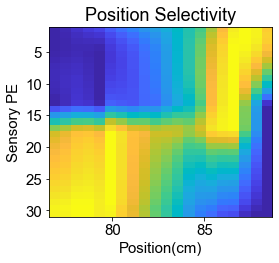

In [57]:
fig, ax_pos = plt.subplots(figsize=heatmap_sz)
# ax_pos.imshow(norm_pes_pos_possenonly, cmap = utils.parula_map,
#                     aspect = 'auto', extent = [ypos_pes_pos[0], ypos_pes_pos[-1], 64 - POS_SEN_UNIT_START, 1], interpolation = 'none')
ax_pos.imshow(norm_pes, cmap=cnn_utils.parula_map,
              aspect='auto', interpolation='none', extent=[ypos_cuep[start_idx], ypos_cuep[-1], 31, 1])

# ax_pos.set_yticks([10, 20, 30]) # , 34
# ax_pos.set_yticklabels(['10', '20', '30'])
ax_pos.spines['right'].set_visible(True)
ax_pos.spines['top'].set_visible(True)
# ax_pos.tick_params(direction="out", length=)
ax_pos.set_title('Position Selectivity')
ax_pos.set_xlabel('Position(cm)');
ax_pos.set_ylabel('Sensory PE');


### Figure 6D: Left/Right Cue Responses

In [12]:
leftCue_ = [trialcue[0][0] - 2 for trialcue in cueOnset_]
rightCue_ = [trialcue[1][0] - 2 for trialcue in cueOnset_]


pes_lcue = cnn_utils.get_timelocked_cues(dist_pes_, leftCue_)
pes_rcue = cnn_utils.get_timelocked_cues(dist_pes_, rightCue_)


# savemat(load_prefix + 'dist_lcuercue.mat',
#         {'mrContra': np.nanmean(pes_lcue[:, :-10, :], 0).T, 'mrIpsi': np.nanmean(pes_rcue[:, :-10, :], 0).T})



In [13]:
vmin = loadmat(load_prefix + 'sorted_dist_lcuercue.mat')['imedg1']
vmax = loadmat(load_prefix + 'sorted_dist_lcuercue.mat')['imedg2']
norm_pes_lcue = loadmat(load_prefix + 'sorted_dist_lcuercue.mat')['mrContra']
norm_pes_rcue = loadmat(load_prefix + 'sorted_dist_lcuercue.mat')['mrIpsi']
sort_order = np.squeeze(
    loadmat(load_prefix + 'sorted_dist_lcuercue.mat')['order']) - 1


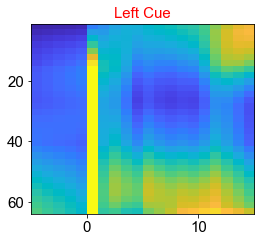

In [14]:

fig, left_ax = plt.subplots(figsize=heatmap_sz)
left_ax.imshow(norm_pes_lcue[:, :-10], aspect='auto', extent=[-5, 15, 64, 1],
               cmap=cnn_utils.parula_map, interpolation='none')  # ,vmin = vmin, vmax = vmax)
left_ax.set_title('Left Cue', color=left_col, fontsize=15)
# left_ax.set_xlabel('Time steps from Cue Onset')
# left_ax.set_ylabel('Vector RPEs', fontsize = FONT_BG)
left_ax.set_yticks([20, 40, 60])  # EX_UNIT_LEFT_IDX,
left_ax.set_yticklabels(['20', '40', '60'])
left_ax.set_xticks([0, 10])

left_ax.spines['right'].set_visible(True)
left_ax.spines['top'].set_visible(True)
# left_ax.tick_params(direction="in", length=10)
left_ax.set_xlabel('Time steps from Left Cue Onset')
left_ax.set_ylabel('Vector RPEs')

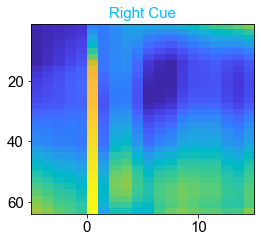

In [15]:

fig, right_ax = plt.subplots(figsize=heatmap_sz)
plot_for_cbar = right_ax.imshow(norm_pes_rcue[:, :-10], aspect='auto', extent=[-5, 15, 64, 1],
                                cmap=cnn_utils.parula_map, interpolation='none')  # , vmin = vmin, vmax = vmax)
right_ax.set_title('Right Cue', color=right_col, fontsize=15)
right_ax.spines['right'].set_visible(True)
right_ax.spines['top'].set_visible(True)
right_ax.set_yticks([20, 40, 60])  # EX_UNIT_RIGHT_IDX,
right_ax.set_yticklabels(['20', '40', '60'])
right_ax.set_xticks([0, 10])
right_ax.set_xlabel('Time steps from Right Cue Onset');
right_ax.set_ylabel('Vector RPEs');

### Figure 6E: Confirm/Disconfirm responses

In [64]:
diff_ = [np.roll(tow_tr[:, 0] - tow_tr[:, 1], 1) for tow_tr in tow_counts_]

leftCue_confirm = [diff_tr[leftCue_[i]] for (i, diff_tr) in enumerate(diff_)]
rightCue_confirm = [diff_tr[rightCue_[i]] for (i, diff_tr) in enumerate(diff_)]

# cues: confirmatory and disconfirmatory
confirmCue_ = [np.sort([*(leftCue_[i])[leftCue_confirm[i] > 0], *(rightCue_[i])
                       [rightCue_confirm[i] < 0]]) for i in np.arange(len(leftCue_))]
dConfirmCue_ = [np.sort([*(leftCue_[i])[leftCue_confirm[i] < 0], *(rightCue_[i])
                        [rightCue_confirm[i] > 0]]) for i in np.arange(len(leftCue_))]


pes_Ccue = cnn_utils.get_timelocked_cues(dist_pes_, confirmCue_)
pes_DCcue = cnn_utils.get_timelocked_cues(dist_pes_, dConfirmCue_)


NameError: name 'leftCue_' is not defined

In [ ]:
timesteps = np.arange(-2, 5)
timesteps_idx = timesteps + 5

units = np.arange(31)
marker_plots_big = {'marker': '.', 'markersize': 5,
                    'markeredgecolor': 'k', 'markerfacecolor': 'k'}

fig = plt.figure(figsize=(10, 6))
scalar_ax = plt.gca()

scalar_ax.errorbar(timesteps, np.nanmean(np.nanmean(pes_Ccue, 0)[:, units], -1)[timesteps_idx],
                   yerr=np.nanstd(np.nanmean(pes_Ccue, 0)[
                                  :, units], -1)[timesteps_idx]/(len(units) - 1),
                   label='Confirm Cue', color='slateblue', capsize=6)
scalar_ax.errorbar(timesteps, np.nanmean(np.nanmean(pes_DCcue, 0)[:, units], -1)[timesteps_idx],
                   yerr=np.nanstd(np.nanmean(pes_DCcue, 0)[
                                  :, units], -1)[timesteps_idx]/(len(units) - 1),
                   label='Disconfirm Cue', color='silver', capsize=6)


scalar_ax.spines['top'].set_visible(False)
scalar_ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.legend()

### Figure 6f-6j: Outcome period plots

In [109]:
dist_rewp = np.dstack([np.vstack([pes_i[-6:, :], np.zeros((5, 31))])
                      for pes_i in dist_pes_])
num_trials = len(ep_tow)
dist_rewp_norm = cnn_utils.norm_within_feat(dist_rewp.transpose((1, 0, 2)).reshape(
    31, 11 * num_trials)).reshape(31, 11, num_trials).transpose(1, 0, 2)

(ep_towdelt_idx, ep_towdiff_idx) = cnn_utils.get_ep_tow_idx(ep_tow)

rew_trials = np.where(ep_rew == 1)[0]
nrew_trials = np.where(ep_rew == 0)[0]
easy_trials = np.hstack(ep_towdelt_idx[5:])
hard_trials = np.hstack(ep_towdelt_idx[:2])

rew_hard = np.sort(list(set(rew_trials) & set(hard_trials)))
rew_easy = np.sort(list(set(rew_trials) & set(easy_trials)))


norm_easy = (np.mean(dist_rewp_norm[:, :, rew_easy], -1).T)[:, 5]
norm_hard = (np.mean(dist_rewp_norm[:, :, rew_hard], -1).T)[:, 5]

norm_nrew = (np.mean(dist_rewp_norm[:, :, nrew_trials], -1).T)[:, 5]
norm_rew = (np.mean(dist_rewp_norm[:, :, rew_trials], -1).T)[:, 5]


In [110]:
dist_rewp[5,:,:]

array([[ 0.32401133,  2.81499261,  1.69357188, ..., -0.83575389,
         0.88003363, -2.61039462],
       [-1.34825247,  3.68199711,  0.88955541, ..., -0.47086959,
        -1.71695922,  1.85007994],
       [ 0.06462353,  1.55604575,  1.35769101, ...,  1.10497129,
         2.21611071,  1.24138905],
       ...,
       [-0.39138543,  2.74567368, -0.17990113, ..., -3.98645089,
        -0.48283977, -1.6199192 ],
       [-2.23097657,  1.48240899, -3.30787538, ...,  0.04286102,
         0.78319298, -0.5775191 ],
       [ 0.24333008,  1.31164817, -1.82445434, ...,  0.80580131,
        -2.44347392, -0.42909142]])

In [75]:
dist_rewp[5, :, :]

array([[ 0.93222553,  0.93755186,  0.94791879, ..., -0.02595907,
         0.941373  ,  0.94004238],
       [ 0.81115604,  0.82494844,  0.85233185, ..., -0.07861359,
         0.83436998,  0.83183984],
       [ 0.70675869,  0.72676637,  0.76730432, ..., -0.13016797,
         0.7397536 ,  0.73773485],
       ...,
       [ 0.04100198,  0.04784823,  0.10996598, ..., -0.78333482,
         0.04217161,  0.04043317],
       [ 0.03643395,  0.04029804,  0.09927136, ..., -0.80175518,
         0.03423785,  0.032093  ],
       [ 0.03129675,  0.02884254,  0.0813892 , ..., -0.82513506,
         0.02312143,  0.02528552]])

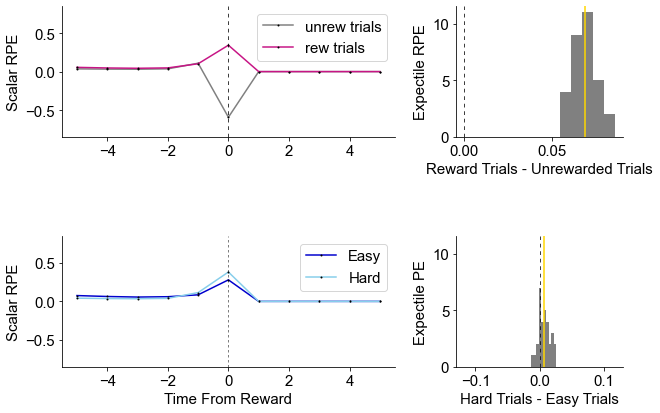

In [111]:

fig = plt.figure(figsize=(9, 6))
SF_to_plot = dist_rewp
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
# easy vs hard

ax_sum_rew = plt.subplot(gs[0, 0])

rew_act = np.nanmean(SF_to_plot[:, :, rew_trials], -1)
nrew_act = np.nanmean(SF_to_plot[:, :, nrew_trials], -1)

ax_sum_rew.plot(np.arange(-5, 6), np.mean(nrew_act, -1),
                **marker_plots,  color='gray', label='unrew trials')
ax_sum_rew.plot(np.arange(-5, 6),  np.mean(rew_act, -1),
                **marker_plots,  color='mediumvioletred', label='rew trials')


ax_sum_rew.set_ylim(-0.85, 0.85)
ax_sum_rew.axvline(0,  ls=(0, (5, 5)), color='k', lw=0.75)

ax_sum_rew.set_ylabel('Scalar RPE')
ax_sum_rew.legend()


ax_hist_rew = plt.subplot(gs[0, 1])

# different bins to make the bins look the same width
_, uniform_bins, _ = ax_hist_rew.hist(
    norm_rew - norm_nrew, color='grey', bins=5)
ax_hist_rew.axvline(np.median(norm_rew - norm_nrew), color='gold')
ax_hist_rew.axvline(0,  ls=(0, (5, 5)), color='k', lw=0.75)
# ax_hist_rew.set_xlim(-1.5, 1.5)

ax_hist_rew.set_xlabel('Reward Trials - Unrewarded Trials')
ax_hist_rew.set_ylabel('Expectile RPE')


ax_sum_rewexp = plt.subplot(gs[1, 0])

colors = sns.color_palette("Blues", n_colors=7)


rew_easy_act = np.nanmean(SF_to_plot[:, :, rew_easy], -1)
rew_hard_act = np.nanmean(SF_to_plot[:, :, rew_hard], -1)

ax_sum_rewexp.plot(np.arange(-5, 6), np.mean(rew_easy_act, -1),
                   **marker_plots, color='mediumblue', label='Easy')

ax_sum_rewexp.plot(np.arange(-5, 6), np.mean(rew_hard_act, -1),
                   **marker_plots, color='skyblue', label='Hard')



ax_sum_rewexp.set_ylim(-0.85, 0.85)
ax_sum_rewexp.axvline(0, color='k', lw=0.5, ls=(0, (5, 5)))

ax_sum_rewexp.legend()
ax_sum_rewexp.set_ylabel('Scalar RPE')
ax_sum_rewexp.set_xlabel('Time From Reward')




ax_hist_rewexp = plt.subplot(gs[1, 1])
ax_hist_rewexp.hist(norm_hard - norm_easy, color='grey', bins=10)
ax_hist_rewexp.axvline(np.median(norm_hard - norm_easy), color='gold')
ax_hist_rewexp.axvline(0,  ls=(0, (5, 5)), color='k', lw=0.75)
ax_hist_rewexp.set_xlim(-0.13, 0.13)
np.median(norm_hard - norm_easy)
ax_hist_rewexp.set_ylim(ax_hist_rew.get_ylim())

ax_hist_rewexp.set_xlabel('Hard Trials - Easy Trials')
ax_hist_rewexp.set_ylabel('Expectile PE')

plt.tight_layout(w_pad=1.3, h_pad=4)



In [112]:
stats.wilcoxon(norm_rew - norm_nrew)


WilcoxonResult(statistic=0.0, pvalue=1.1741945398998534e-06)

In [113]:
stats.wilcoxon(norm_hard - norm_easy)

WilcoxonResult(statistic=53.0, pvalue=0.00013273589812356102)